# INF-510, v0.2, Claudio Torres, ctorres@inf.utfsm.cl. DI-UTFSM

# Fast sum of sinc!

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import scipy.sparse.linalg as sp
from scipy import interpolate
import scipy as spf
from sympy import *
import sympy as sym
from scipy.linalg import toeplitz
from ipywidgets import interact
from ipywidgets import IntSlider
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
# The variable M is used for changing the default size of the figures
M=5

## The magical and beautiful sinc function

In [5]:
def Sh2(x):
    if np.abs(x)<=1e-10:
        return 1.0
    else:
        y=x
        return np.sin(y)/y
Sh2v = np.vectorize(Sh2) 

In [6]:
# The domain
L=10
# The number of points 
N=100
x=np.linspace(-L,L,100)

# Fixing randomness
np.random.seed(0)

# The weights
y=np.random.rand(N)*2-1


In [7]:
# The simple algorithm
def F(xx,x,y,i=None):
    n = x.shape[0]
    n_out = xx.shape[0] 
    out = np.zeros(n_out)
    # Plots all sincs
    if i==None:
        for i in np.arange(n):
            out+=y[i]*Sh2v(xx-x[i])
    else: # Just plot one sinc
        out+=y[i]*Sh2v(xx-x[i])
    return out
def F_pre_fast(xx,x,y,m,x_bar):
    n = x.shape[0]
    n_out = xx.shape[0] 
    out = np.zeros(n_out)
    # First sum: sin
    for i in np.arange(n):
        out2=0
        for j in np.arange(m):
            out2+=(x[i]-x_bar)**j/(xx-x_bar)**(j+1)
        out+=y[i]*np.cos(x[i])*out2
    out*=np.sin(xx)
    # Second sum: cos
    out3=0
    for i in np.arange(n):
        out4=0
        for j in np.arange(m):
            out4+=(x[i]-x_bar)**j/(xx-x_bar)**(j+1)
        out3+=y[i]*np.sin(x[i])*out4
    out3*=np.cos(xx)
    return out-out3
F_pre_fastv = np.vectorize(F_pre_fast) 

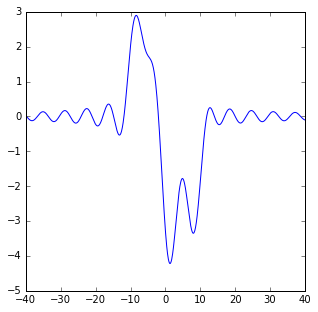

In [8]:
xx=np.linspace(-4*L,4*L,10*N)
yy=F(xx,x,y)
plt.figure(figsize=(M,M))
plt.plot(xx,yy)
plt.show()

In [9]:
# Computing 'fast' coefficients
def compute_coefficients(x,y,m,x_bar):
    coef_cos=np.zeros(m)
    coef_sin=np.zeros(m)
    coef_cos[0]=np.sum(y*np.cos(x))
    coef_sin[0]=np.sum(y*np.sin(x))
    y_cos_x=y*np.cos(x)
    y_sin_x=y*np.sin(x)
    for j in np.arange(1,m):
        coef_cos[j]=np.sum(y_cos_x*((x-x_bar)**j))
        coef_sin[j]=np.sum(y_sin_x*((x-x_bar)**j))
    return coef_cos,coef_sin
# Evaluate fast sums with coefficients pre-computed (this is the real trick: pre-computacion!)
def evaluate_fast_sum(xx,coef_cos,coef_sin,x_bar):
    m=coef_sin.shape[0]
    # Coefficient j=0
    out_cos=np.zeros(xx.shape[0])
    out_sin=np.zeros(xx.shape[0])
    for j in np.arange(m):
        out_cos+=coef_cos[j]/((xx-x_bar)**(j+1))
        out_sin+=coef_sin[j]/((xx-x_bar)**(j+1))
    return np.sin(xx)*out_cos-np.cos(xx)*out_sin
evaluate_fast_sumv = np.vectorize(evaluate_fast_sum) 

In [10]:
# Slicing the data
mask_inner = (x<=-L/2)
mask_far_away = (x>=0)
x_inner = x[mask_inner]
y_inner = y[mask_inner]
x_far_away = x[mask_far_away]
y_far_away = y[mask_far_away]

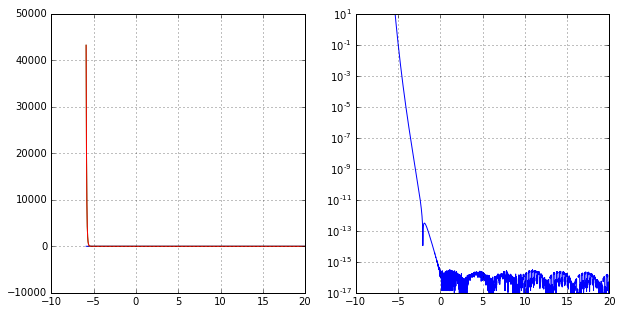

In [15]:
def change_m(m=1):
    x_bar=x_inner[int(x_inner.shape[0]/2)]
    coef_cos,coef_sin=compute_coefficients(x_inner,y_inner,m,x_bar)

    xx=np.linspace(np.min(x_far_away)-6,np.max(x_far_away)*2,40*N)
    
    # Original
    yy=F(xx,x_inner,y_inner)

    # Pre fast without rearrangements
    yy_pre_fast=F_pre_fast(xx,x_inner,y_inner,m,x_bar)

    # My first 'Fast' sum. Finally!
    yy_f=evaluate_fast_sum(xx,coef_cos,coef_sin,x_bar)

    fig = plt.figure(figsize=(2*M,M))

    plt.subplot(121)
    plt.plot(xx,yy,'b')
    plt.plot(xx,yy_pre_fast,'g')
    plt.plot(xx,yy_f,'r')
    plt.grid(True)
    
    plt.subplot(122)
    plt.semilogy(xx,np.abs(yy-yy_f),'b')
    plt.grid(True)
    plt.ylim((1e-17,1e1))
    plt.show()
interact(change_m,m=(1,50,1))